# Aviation Risk Analysis Project

Authors: Brian Woo, Evan Rosenbaum

## Overview

This project involves data cleaning, imputation, analysis, and visualization to generate insights for a business stakeholder. The goal is to determine the lowest risk aircraft for a company looking to expand into the aviation industry.

# Business Problem

## Stakeholder - US based (Domestic Flights)

The stakeholder for this project is the head of the new aviation division within the company.

### Key Business Questions

1. Which aircraft types have the lowest risk based on historical accident data?
2. What are the common causes of aircraft accidents?
3. How can the company use this information to make informed decisions about purchasing aircraft?


## Source of Data

The dataset used for this project is from the National Transportation Safety Board (NTSB) and includes aviation accident data from 1962 to 2023. This dataset covers civil aviation accidents and selected incidents in the United States and international waters.

# Understanding the Data Structure

In [1]:
# Import standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Open the file in read mode and read lines

aviation_df = pd.read_csv('./data_files/AviationData.csv', encoding='latin-1')

state_codes_df = pd.read_csv('./data_files/USState_Codes.csv', encoding='latin-1')

In [3]:
state_codes_df

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
...,...,...
57,Virgin Islands,VI
58,Washington_DC,DC
59,Gulf of mexico,GM
60,Atlantic ocean,AO


In [4]:
# Changing the naming convention of columns
aviation_df.columns = aviation_df.columns.str.lower().str.replace('.', '_')
aviation_df.columns

Index(['event_id', 'investigation_type', 'accident_number', 'event_date',
       'location', 'country', 'latitude', 'longitude', 'airport_code',
       'airport_name', 'injury_severity', 'aircraft_damage',
       'aircraft_category', 'registration_number', 'make', 'model',
       'amateur_built', 'number_of_engines', 'engine_type', 'far_description',
       'schedule', 'purpose_of_flight', 'air_carrier', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured',
       'weather_condition', 'broad_phase_of_flight', 'report_status',
       'publication_date'],
      dtype='object')

In [5]:
# Apply lambda function to remove whitespace from every element in the DataFrame
aviation_df = aviation_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [6]:
# Drops duplicate rows
aviation_df.drop_duplicates(inplace=True)

In [7]:
aviation_df.shape

(88889, 31)

In [8]:
aviation_df

,event_id,investigation_type,accident_number,event_date,location,country,latitude,longitude,airport_code,airport_name,...,purpose_of_flight,air_carrier,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,weather_condition,broad_phase_of_flight,report_status,publication_date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88884,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022
88885,20221227106494,Accident,ERA23LA095,2022-12-26,"Hampton, NH",United States,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
88886,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,...,Personal,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022
88887,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,NaN,NaN,...,Personal,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


# Data Types and Missing Values

In [9]:
aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   event_id                88889 non-null  object 
 1   investigation_type      88889 non-null  object 
 2   accident_number         88889 non-null  object 
 3   event_date              88889 non-null  object 
 4   location                88837 non-null  object 
 5   country                 88663 non-null  object 
 6   latitude                34382 non-null  object 
 7   longitude               34373 non-null  object 
 8   airport_code            50249 non-null  object 
 9   airport_name            52790 non-null  object 
 10  injury_severity         87889 non-null  object 
 11  aircraft_damage         85695 non-null  object 
 12  aircraft_category       32287 non-null  object 
 13  registration_number     87572 non-null  object 
 14  make                    88826 non-null

### Missing values

In [10]:
# Percent of missing values in each column
aviation_df.isna().sum() * 100 / len(aviation_df)

event_id                   0.000000
investigation_type         0.000000
accident_number            0.000000
event_date                 0.000000
location                   0.058500
country                    0.254250
latitude                  61.320298
longitude                 61.330423
airport_code              43.469946
airport_name              40.611324
injury_severity            1.124999
aircraft_damage            3.593246
aircraft_category         63.677170
registration_number        1.481623
make                       0.070875
model                      0.103500
amateur_built              0.114750
number_of_engines          6.844491
engine_type                7.961615
far_description           63.974170
schedule                  85.845268
purpose_of_flight          6.965991
air_carrier               81.271023
total_fatal_injuries      12.826109
total_serious_injuries    14.073732
total_minor_injuries      13.424608
total_uninjured            6.650992
weather_condition          5

In [11]:
# Number of unique and missing values
unique_missing_vals = {}
for i in aviation_df.columns:
    unique_missing_vals[i] = len(aviation_df[i].unique())

unique_values= pd.DataFrame(list(unique_missing_vals.items()), columns = ['Column', 'unique_val'])
unique_values["missing_values"] = aviation_df.isna().sum().values
unique_values

,Column,unique_val,missing_values
0,event_id,87951,0
1,investigation_type,2,0
2,accident_number,88863,0
3,event_date,14782,0
4,location,27758,52
5,country,220,226
6,latitude,25593,54507
7,longitude,27157,54516
8,airport_code,10376,38640
9,airport_name,24872,36099


# Descriptive Statistics

In [12]:
aviation_df.describe()

,number_of_engines,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured
count,82805.000000,77488.000000,76379.000000,76956.000000,82977.000000
mean,1.146585,0.647855,0.279881,0.357061,5.325440
std,0.446510,5.485960,1.544084,2.235625,27.913634
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


### Analysis of Statistics

- There are large outlier inside of all of the injury metrics. However, these outliers are important and give us valuable information about the riskiness of the aircraft.

- We should not remove these outliers.


In [13]:
aviation_df.mode().T

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
event_id,20001212X19172,20001214X45071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
investigation_type,Accident,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
accident_number,CEN22FA424,CEN22LA149,CEN22LA346,CEN23MA034,DCA22LA135,DCA22LA201,DCA22WA089,DCA22WA130,DCA22WA158,DCA22WA167,...,ERA22LA103,ERA22LA119,ERA22LA364,ERA22LA379,GAA22WA241,WPR22FA309,WPR22LA143,WPR22LA201,WPR23LA041,WPR23LA045
event_date,1982-05-16,1984-06-30,2000-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,"ANCHORAGE, AK",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,332739N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
longitude,0112457W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airport_code,NONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airport_name,Private,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [14]:
def column_info(dataframe, column):
    """
    Provides a view into the row information provided in each column
    -
    Input:
    dataframe : Pandas DataFrame
    columns_list: list 
    -
    Output:
        Prints:
            - A preview of the first 5 values in the column.
            - Value counts of the column.
            - The percentage of missing values in the column.
    """
    preview = dataframe[column].head()
    value_counts = dataframe[column].value_counts()
    percent_missing = dataframe[column].isna().sum() * 100 / len(dataframe)
    
    print("Preview of the first 5 rows in the column:")
    print(preview)
    print("\nValue counts of the column:")
    print(value_counts)
    print("\nPercentage of missing values in the column:")
    print(f"{percent_missing:.2f}%") 

## Normalizing Columns

For the following columns, we are normalizing the casing to account of duplicated entries.

In [15]:
# List of columns
columns_to_lowercase = [
    'investigation_type',
    'injury_severity',
    'aircraft_damage',
    'aircraft_category',
    'make',
    'amateur_built',
    'engine_type',
    'purpose_of_flight',
    'broad_phase_of_flight' 
]

# Convert the columns to lowercase
for column in columns_to_lowercase:
    aviation_df[column] = aviation_df[column].str.lower()

## Filtering the Data 

### location and country

In [16]:
# Preview the row entries for the column
column_info(aviation_df,'location')

Preview of the first 5 rows in the column:
0    MOOSE CREEK, ID
1     BRIDGEPORT, CA
2      Saltville, VA
3         EUREKA, CA
4         Canton, OH
Name: location, dtype: object

Value counts of the column:
ANCHORAGE, AK           434
MIAMI, FL               200
ALBUQUERQUE, NM         196
HOUSTON, TX             193
CHICAGO, IL             184
                       ... 
WOODEBERRY, TN            1
Tooradin, Australia       1
Christiansted,            1
Wijnendaele, Belgium      1
Amboise, OF               1
Name: location, Length: 27757, dtype: int64

Percentage of missing values in the column:
0.06%


In [17]:
# Check for missing values
aviation_df['location'].isna().sum()

52

In [18]:
# Row entry review

# Copy the DataFrame so no data is lost
aviation_df_copy = aviation_df.copy()

# Fill NaN values with a blank string
aviation_df_copy['location'].fillna('', inplace=True)

# Apply the filter
aviation_df_copy[aviation_df_copy['location'].str.contains('NEAR')]['location']

33        NEAR LAS VEGAS, NV
50       NEAR BAKERSFIEL, CA
75          NEAR BOZEMAN, MT
95          NEAR NUIQSUT, AK
127         NEAR LANSING, MI
                ...         
24104     NEAR TALKEETNA, AK
24268      NEAR COLD BAY, AK
28190       NEAR ILIAMNA, AK
33498      NEAR SKWENTNA, AK
48186      NEAR MUSKEGON, MI
Name: location, Length: 167, dtype: object

In [19]:
# Show if there is a country listed for location values that are NaNs
aviation_df['location'][aviation_df['country'] != 'United States'].value_counts()

ATLANTIC OCEAN            81
SAN JUAN                  53
London, United Kingdom    48
PACIFIC OCEAN             45
GULF OF MEXICO            30
                          ..
SAN JUANITO, MEXICO        1
Herzogenaurach,            1
Luziania, Brazil           1
CUXHAVEN, Germany          1
MACAE, BRAZIL              1
Name: location, Length: 4731, dtype: int64

**Review**

The location column while providing more detail than the country file has some issues.

First is that not every entry has an accurate city location.

Second is that for foreign countries, there are multiple comma delimters indentifying the city. Additionally, the country is listed inside of the location.

**Examples**

- Los Mochis, Sinaloa, Mexico
- Ledbury, Herefordshire, United Kingdom
- Panama City, Panama
- Ji'an City Jiangxi Province, China

**Recommendation**

- Filter the data set so that we only have US flights.
- Create a state category so we can reliably use the consistent information for location.
- Drop the country and location columns. 

**Action**

In [20]:
# Filter for only the rows the country is the United States
aviation_df = aviation_df[aviation_df['country'] == 'United States']

# Drop NaN values from location
aviation_df.dropna(subset=['location'], inplace=True)

# Create a new column 'state' that holds the state information from the location column
aviation_df['state'] = aviation_df['location'].apply(lambda x: x.split(',')[-1].strip())

# Drop the 'location' column
aviation_df.drop(columns=['location'], inplace=True)

# Drop the 'country' column
aviation_df.drop(columns=['country'], inplace=True)

# Merge the csv DataFrames on the 'state' column in aviation_df and 'Abbreviation' column in state_codes_df
aviation_df = pd.merge(aviation_df, state_codes_df, left_on='state', right_on='Abbreviation', how='inner')

# Drop the 'Abbreviation' column as it's no longer needed
aviation_df.drop(columns=['Abbreviation'], inplace=True)

# Drop the 'Abbreviation' column as it's no longer needed
aviation_df.drop(columns=['US_State'], inplace=True)

### investigation_type

In [21]:
# Preview the row entries for the column
column_info(aviation_df,'investigation_type')

Preview of the first 5 rows in the column:
0    accident
1    accident
2    accident
3    accident
4    incident
Name: investigation_type, dtype: object

Value counts of the column:
accident    79826
incident     2327
Name: investigation_type, dtype: int64

Percentage of missing values in the column:
0.00%


**Review**

Events are classified as either being accidents or incidents. 

According to the Code of Federal Regulations, "an accident is defined as an occurrence associated with the operation of an aircraft which takes place between the time any person boards the aircraft with the intention of flight and all such persons have disembarked, and in which any person suffers death or serious injury, or in which the aircraft receives substantial damage. For purposes of this part, the definition of “aircraft accident” includes “unmanned aircraft accident,” as defined herein."

An incident is defined as "an occurrence other than an accident, associated with the operation of an aircraft, which affects or could affect the safety of operations."

https://www.ecfr.gov/current/title-49/subtitle-B/chapter-VIII/part-830/subpart-A/section-830.2

**Recommendation**

Narrow our search to only include records that are labeled as accident. 
- This would result in about 5% of the total data being dropped.

**Action**

In [22]:
# Filter the event_id column for only accidents
aviation_df = aviation_df[aviation_df['investigation_type'] != 'incident']

## Analysis for Columns to Drop

### Columns with Unique Identifiers

- event_id
    - The event_id serves as a unqiue indentifier for each row entry. These are for reference to search the event on the NTSB aviation accident database.
- accident_number
    - The accident_number serves as a unqiue indentifier for each row entry. These are for reference to search the event on the NTSB aviation accident database.
- registration_number
    - It is unclear why there is missing values or duplicated values inside of this column as one would assume that every aircrafts registration number would be unique.
    - No documentation on this column could be located to provide further information.

### Columns with missing values above 50%

**Overview**

These columns contain too much missing data. Additionally, they are not pertinent to the business question. 

**Specific Column Information**

- latitude
- longitude
- far_description
    - The column contains references to the Federal Aviation Regulations (FARs) or similar regulatory categories. The FARs are a set of rules prescribed by the Federal Aviation Administration (FAA) governing all aviation activities in the United States.
    - The values are not normalized and contain duplicates.
     - Examples:
        - Part 91: General Aviation
            - Covers general operating and flight rules for all aircraft not governed by other specific parts (e.g., private pilots, corporate flights, etc.).
        - PUBU: Public Use
             - Refers to aircraft operated by government agencies or other public entities for official purposes.
        - https://www.faa.gov/hazmat/air_carriers/operations
        - https://www.ecfr.gov/current/title-14
- schedule
    - No documentation on this column could be located to provide further information.

### Columns with insignficant data in reference to business question

**Overview**

These columns while providing interesting information do not provide pertinent information in relation to the busines question. 

- airport_code
- airport_name
- air_carrier
- publication_date

### Action to Drop Columns

In [23]:
# drop the columns that are not useful for analysis
columns_to_drop = [
    'event_id',
    'accident_number',
    'latitude',
    'longitude',
    'airport_code',
    'airport_name',
    'registration_number',
    'far_description',
    'schedule',
    'air_carrier',
    'publication_date',
]

aviation_df.drop(columns=columns_to_drop, inplace=True)

## Analysis for Dropping Row NaN's

### make and model

**Overview**

We want to ensure there is a make and model for every row element. If there is no make and mode, we cannot give a recommendation to the business. 

**Action**

In [24]:
# Drop missing values inside of the 'make' column
aviation_df.dropna(subset=['make', 'model'], inplace=True)

## Analysis for Columns to Replace NaN's

### Columns with no pre-existing unknown category

For each of these columns, there are no pre-existing unknown or other categories. 

As such, we are filling the NaN values with an 'unknown' string. 

In [25]:
columns_to_replace_with_unknown = [
    'purpose_of_flight',
    'report_status',
    'aircraft_damage',
    'aircraft_category',
    'model',
    'amateur_built'
]

aviation_df[columns_to_replace_with_unknown] = aviation_df[columns_to_replace_with_unknown].fillna('unknown')

### Columns with pre-existing unknown category (UNK, Unknown, Other)

In [26]:
# find Columns with pre-existing unknown category (UNK, Unknown, Other, None) and replace them with 'unknown'
columns_to_replace_with_unknown = [
    'investigation_type',
    'event_date',
    'injury_severity', 
    'aircraft_damage',
    'aircraft_category',
    'make',
    'model',
    'amateur_built',
    'engine_type',
    'purpose_of_flight',
    'weather_condition',
    'broad_phase_of_flight',
    'report_status'
]

replace_values = ['unk', 'unknown', 'other', 'none', 'unavailable', np.nan]

aviation_df[columns_to_replace_with_unknown] = aviation_df[columns_to_replace_with_unknown].applymap(
    lambda x: 'unknown' if isinstance(x, str) and x.lower() in replace_values or pd.isna(x) else x)


## Imputing Numerical Column Values

### total_fatal_injuries, total_serious_injuries, total_minor_injuries and total_uninjured

**Overview**

The total_fatal_injuries, total_serious_injuries, total_minor_injuries, and total_uninjured columns were replaced with the median values of the column.

In [27]:
injury_columns = [
    'total_fatal_injuries', 
    'total_serious_injuries', 
    'total_minor_injuries', 
    'total_uninjured'
]

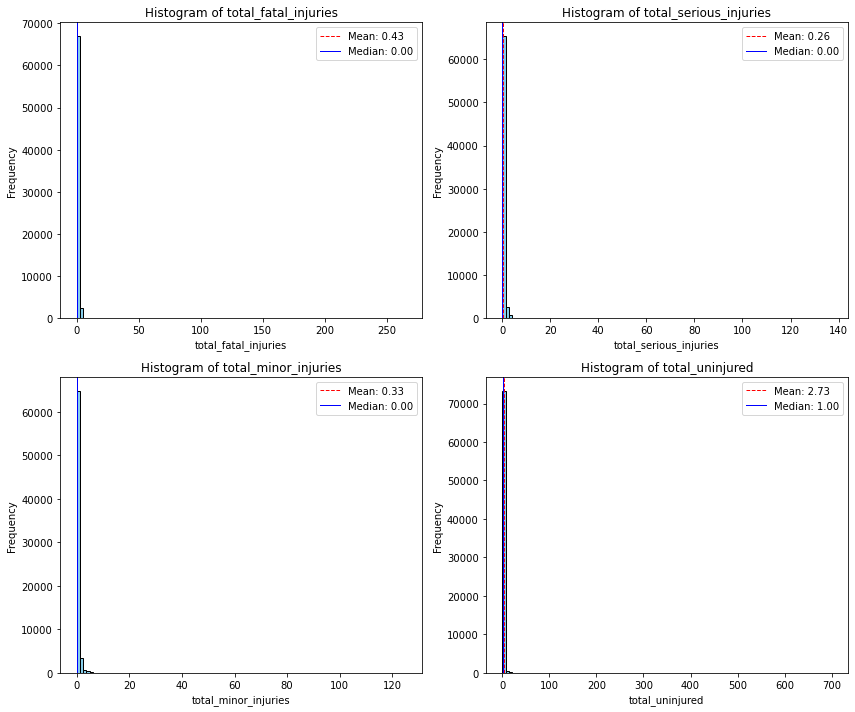

In [28]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over each column and plot a histogram
for i, column in enumerate(injury_columns):
    # Drop NaN values before plotting
    data = aviation_df[column].dropna()
    
    # Plot histogram
    axes[i].hist(data, bins=100, color='skyblue', edgecolor='black')
    
    # Calculate mean and median
    mean_val = data.mean()
    median_val = data.median()
    
    # Draw vertical lines for mean and median
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='blue', linestyle='-', linewidth=1, label=f'Median: {median_val:.2f}')
    
    # Set title for each subplot
    axes[i].set_title(f'Histogram of {column}')
    
    # Set labels for x and y axes
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    
    # Add legend
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


**Overview**

Given the positve skew of each column, we will impute the missing values with the median. 

**Action**

In [29]:
# Imputing the missing values with the median
aviation_df[injury_columns] = aviation_df[injury_columns].apply(lambda x: x.fillna(x.median()))

In [30]:
# Creating 'total_injuries' column
aviation_df['total_injuries'] = aviation_df[
    ['total_fatal_injuries', 
     'total_serious_injuries', 
     'total_minor_injuries'
    ]
].sum(axis=1)

### number_of_engines

**Overview**

The number_of_engines had to be done differently because, it would be better to be true to the data, because it is impossible to correlate the number of engines in a plane.

Big planes could have 1 engine, while another big plane of the same sizes could have 2 or more engines

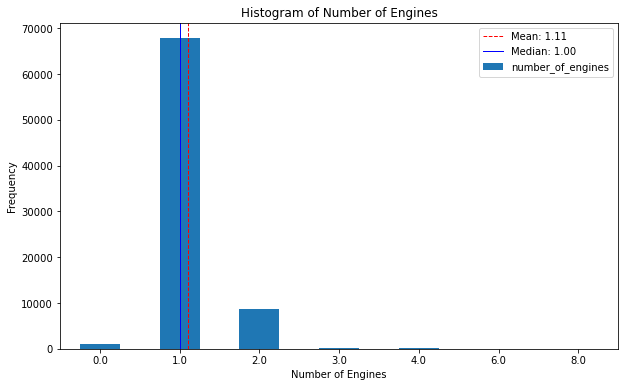

In [31]:
# Get values for histogram
value_counts = aviation_df['number_of_engines'].value_counts().sort_index()

# Calculate mean and median
mean_num_engines = aviation_df['number_of_engines'].mean()
median_num_engines = aviation_df['number_of_engines'].median()

# Plot a histogram of the value counts
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.xlabel('Number of Engines')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Engines')
plt.xticks(rotation=0)

# Add vertical lines for mean and median
plt.axvline(x=mean_num_engines, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_num_engines:.2f}')
plt.axvline(x=median_num_engines, color='blue', linestyle='-', linewidth=1, label=f'Median: {median_num_engines:.2f}')

# Add legend
plt.legend()

# Show the plot
plt.show()

**Review**

The column is missing values. 

**Recommendation**

We could fill the missing values with the median value, however since passing the median will falsely represent the data, we will treat the column as categorical data. 

We will the column type to object and fill the missing values with an unknown category.

**Action**

In [32]:
aviation_df['number_of_engines'] = aviation_df['number_of_engines'].fillna('unknown')

### Adding New Columns and Cleaning Individual Columns

#### New Columns

In [33]:
# Adding 'total_injuries' column
aviation_df['total_injuries'] = (
    aviation_df['total_fatal_injuries'] +
    aviation_df['total_serious_injuries'] +
    aviation_df['total_minor_injuries']
)

# Adding 'year', 'month', and 'day' columns
aviation_df['event_date'] = pd.to_datetime(aviation_df['event_date'])
aviation_df['year'] = aviation_df['event_date'].dt.year
aviation_df['month'] = aviation_df['event_date'].dt.month
aviation_df['day'] = aviation_df['event_date'].dt.day

aviation_df.drop(columns=['event_date'], inplace=True)

#### Cleaning Individual Columns

##### injury_severity

In [34]:
# Removing the count that follows the description of the injury in the 'injury_severity column'
aviation_df['injury_severity'] = aviation_df['injury_severity'].apply(lambda x: x.split('(')[0])

##### make

In [35]:
# Create a dictionary to store the mapping of individual make names to origin names
make_origin_mapping = {}

# Iterate over each make in aviation_df to extract the origin name
for make in aviation_df['make'].unique():
    origin_make = make.split()[0]  # Get the origin make ('mcdonnell douglas helicopter' from 'mcdonnell')
    make_origin_mapping[make] = origin_make
    
aviation_df['make'] = aviation_df['make'].map(make_origin_mapping)

###### Commerical Jet Cleaning

The two major players in commerical airline manufacturing are Boeing and Airbus. The have operated a duoply over the commerical airline industry since the 1990's. 

According to reports by CNBC, Airbus and Boeing together account for 99% of all large aircraft orders (and these orders together account for 90% of all aircraft sales). 

- CNBC article is no longer avaliable, written in 2019
- https://simpleflying.com/battle-of-big-planes/

In [36]:
# Find unique values where make is airbus and the engine_type is turbo fan

new_df = aviation_df[(aviation_df['engine_type'] == 'turbo fan')][['make', 'model', 'engine_type', 'purpose_of_flight']].value_counts().reset_index()

instances = new_df[new_df['make'].str.contains('airbus', case=False)]

unique_instances = instances['model'].unique()

for instance in unique_instances:
    print(instance)

A320-232
A330-323
A321 231
A321
A319
A320
A330 323
A-320-231
A-320-232
320
A-319-114
A300B4-605R
A319 132
A319-111
A319-112
A319-114
A320 212
A330
A-300-605R
A319-131
A319-100
A319 115
A319 114
A319 112
A300B4-2C
A300B4-203
A300-600F
A300 - F4 622R
A-320-211
A-320-200
A-319-112
A-300B4-605R
A-300-B4-203
A-300-600ER
A-300 B4-203
A-300
330
321
319-131
A320 - 214
A320 211
A320 214
A320 232
F4-622R
A380
A340-300
A340 - 300
A330-223
A321-271N
A321-231
A320-321
A320-231
A320-212
A320-211


In [70]:
airbus_replace_dict = {
    'A320-232' : 'A320',
    'A330-323' : 'A330',
    'A321 231' : 'A321',
    'A330 323' : 'A330',
    'A-320-231' : 'A320',
    'A-320-232' : 'A320',
    '320' : 'A320',
    'A-319-114' : 'A319',
    'A300B4-605R' : 'A300',
    'A319 132' : 'A319',
    'A319-111' : 'A319',
    'A319-112' : 'A319',
    'A319-114' : 'A319',
    'A320 212' : 'A320',
    'A-300-605R' : 'A300',
    'A319-131' : 'A319',
    'A319-100' : 'A319',
    'A319 115' : 'A319',
    'A319 114' : 'A319',
    'A319 112' : 'A319',
    'A300B4-2C' : 'A300',
    'A300B4-203' : 'A300',
    'A300-600F' : 'A300',
    'A300 - F4 622R' : 'A300',
    'A-320-211' : 'A320',
    'A-320-200' : 'A320',
    'A-319-112' : 'A319',
    'A-300B4-605R' : 'A300',
    'A-300-B4-203' : 'A300',
    'A-300-600ER' : 'A300',
    'A-300 B4-203' : 'A300',
    'A-300' : 'A300',
    '330' : 'A330',
    '321' : 'A321',
    '319-131' : 'A319',
    'A320 - 214' : 'A320',
    'A320 211' : 'A320',
    'A320 214' : 'A320',
    'A320 232' : 'A320',
    'F4-622R' : 'A300',
    'A340-300' : 'A340',
    'A340 - 300' : 'A340',
    'A330-223' : 'A330',
    'A321-271N' : 'A321',
    'A321-231' : 'A321',
    'A320-321' : 'A320',
    'A320-231' : 'A320',
    'A320-212' : 'A320',
    'A320-211' : 'A320',
}

In [71]:
# Find unique values where the make is boeing and the engine_type is turbo fan

new_df = aviation_df[(aviation_df['engine_type'] == 'turbo fan')][['make', 'model', 'engine_type', 'purpose_of_flight']].value_counts().reset_index()

instances = new_df[new_df['make'].str.contains('boeing', case=False)]

unique_instances = instances['model'].unique()

for instance in unique_instances:
    print(instance)

737
757
727
747
767
777
717
707
MD-11
MD-10
DC-10
787
747 SP-09


In [97]:
boeing_replace_dict = {
    '737-300' : '737',
    '737' : '737',
    '757-232' : '757',
    '737 7H4' : '737',
    '737-200' : '737',
    '757-222' : '757',
    '737-7H4' : '737',
    '727-200' : '727',
    '737-700' : '737',
    '717-200' : '717',
    '747-400' : '747',
    '757-223' : '757',
    '737-322' : '737',
    '737-222' : '737',
    '757-200' : '757',
    '747-136' : '747',
    '767-300' : '767',
    '737-500' : '737',
    '727-224' : '727',
    '747-122' : '747',
    '757-251' : '757',
    '737-3H4' : '737',
    '737-8H4' : '737',
    '767-200ER' : '767',
    '737 3H4' : '737',
    '767-200' : '767',
    '727-223' : '727',
    '727-100' : '727',
    '737-232' : '737',
    '767-332ER' : '767',
    '727-235' : '727',
    '727-232' : '727',
    '727-222' : '727',
    '777-222' : '777',
    '767-332' : '767',
    '707-323C' : '707',
    '737-832' : '737',
    '737-823' : '737',
    '737-724' : '737',
    '737-400' : '737',
    '737-291' : '737',
    '747-422' : '747',
    '757-2G7' : '757',
    '747-200' : '747',
    '747-300' : '747',
    '757 223' : '757',
    '747-121' : '747',
    '757-2B7' : '757',
    '757-2S7' : '757',
    '757-33N' : '757',
    '767-223' : '767',
    '777-200' : '777',
    '777-223' : '777',
    'B-737-300' : '737',
    '757-24APF' : '757',
    '737 832' : '737',
    '737 824' : '737',
    '737 76N' : '737',
    '727-251' : '727',
    '727-233' : '727',
    '727-225A' : '727',
    '727-214' : '727',
    '737-201' : '737',
    '727-225' : '727',
    '737-732' : '737',
    '737-49R' : '737',
    '737-3A4' : '737',
    '737-800' : '737',
    '737-2X6C' : '737',
    '737-2H4' : '737',
    '737 924' : '737',
    '737-522' : '737',
    '737-4Q8' : '737',
    '737-4B7' : '737',
    '737-3S3' : '737',
    '737-3M8 (300)' : '737',
    '737-3G7' : '737',
    '737-387' : '737',
    '737-300LR' : '737',
    '737-2B7' : '737',
    '737-297' : '737',
    '737-291A' : '737',
    '737-277' : '737',
    '737-247' : '737',
    '737-204' : '737',
    '737-790' : '737',
    '737 76Q' : '737',
    '737 724' : '737',
    '737 330' : '737',
    '737 - 932ER' : '737',
    '727-51C' : '727',
    '727-31' : '727',
    '727-295' : '727',
    '727-264' : '727',
    '727-247' : '727',
    '727-243' : '727',
    '727-230' : '727',
    '727-23' : '727',
    '727-227' : '727',
    '737-72T' : '737',
    '737-924' : '737',
    '747-287B' : '747',
    '767-201' : '767',
    '767 34AF' : '767',
    '767 332' : '767',
    '767 328' : '767',
    '767 322' : '767',
    '757-351' : '757',
    '757-2Q8' : '757',
    '757-231' : '757',
    '757 2B7' : '757',
    '747SP-21' : '747',
    '747SP' : '747',
    '747-SP' : '747',
    '747-4F6B' : '747',
    '747-368' : '747',
    '747-269B' : '747',
    '737-924ER' : '737',
    '747-256' : '747',
    '747-243B' : '747',
    '747-238' : '747',
    '747-236B' : '747',
    '747-236' : '747',
    '747-230' : '747',
    '747-228F' : '747',
    '747-212B' : '747',
    '747-200F' : '747',
    '747-200B' : '747',
    '747-131' : '747',
    '747-128' : '747',
    '747 SP-09' '747': '747',
    '737-932ER' : '737',
    '727-222A' : '727',
    '727-212' : '727',
    '727 200' : '727',
    '717 200' : '717',
    '707-351C' : '707',
    '707-324C' : '707',
    '707-321B' : '707',
    '707-300' : '707',
    '767-222' : '767',
    '767-232' : '767',
    '767-300ER' : '767',
    '767-323ER' : '767',
    'B757-200' : '757',
    'MD-10-10F' : 'MD-10',
    'BOEING 777-236' : '777',
    'B777-222' : '777',
    'B767-300' : '767',
    'B767-287ER' : '767',
    'B757-232' : '757',
    'B737-800' : '737',
    'B737-300' : '737',
    'B-757-222' : '757',
    'B-737-832' : '737',
    'B-737' : '737',
    '777-300' : '777',
    '777-281' : '777',
    '777-236' : '777',
    '777-233ER' : '777',
    '777-232' : '777',
    '777-22B' : '777',
    '777-200ER' : '777',
    '777 223' : '777',
    '777 - 236' : '777',
    '747 SP-09' : '747',
    'DC-10' : 'MD-10'
}

In [98]:
# Apply the replacements for Airbus
aviation_df['model'] =aviation_df['model'].replace(airbus_replace_dict)

# Apply the replacements for Boeing
aviation_df['model'] = aviation_df['model'].replace(boeing_replace_dict)

In [99]:
# Create 'make_model' column
aviation_df['make_model'] = aviation_df['make'] + ' ' + aviation_df['model']

In [42]:
# Cleaned Dataset
aviation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79786 entries, 0 to 82152
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   investigation_type      79786 non-null  object 
 1   injury_severity         79786 non-null  object 
 2   aircraft_damage         79786 non-null  object 
 3   aircraft_category       79786 non-null  object 
 4   make                    79786 non-null  object 
 5   model                   79786 non-null  object 
 6   amateur_built           79786 non-null  object 
 7   number_of_engines       79786 non-null  object 
 8   engine_type             79786 non-null  object 
 9   purpose_of_flight       79786 non-null  object 
 10  total_fatal_injuries    79786 non-null  float64
 11  total_serious_injuries  79786 non-null  float64
 12  total_minor_injuries    79786 non-null  float64
 13  total_uninjured         79786 non-null  float64
 14  weather_condition       79786 non-null

# Outliers Detection

## Numerical Columns

In [43]:
numerical_columns = [
    'total_fatal_injuries',
    'total_serious_injuries',
    'total_minor_injuries',
    'total_uninjured',
    'total_injuries'
]

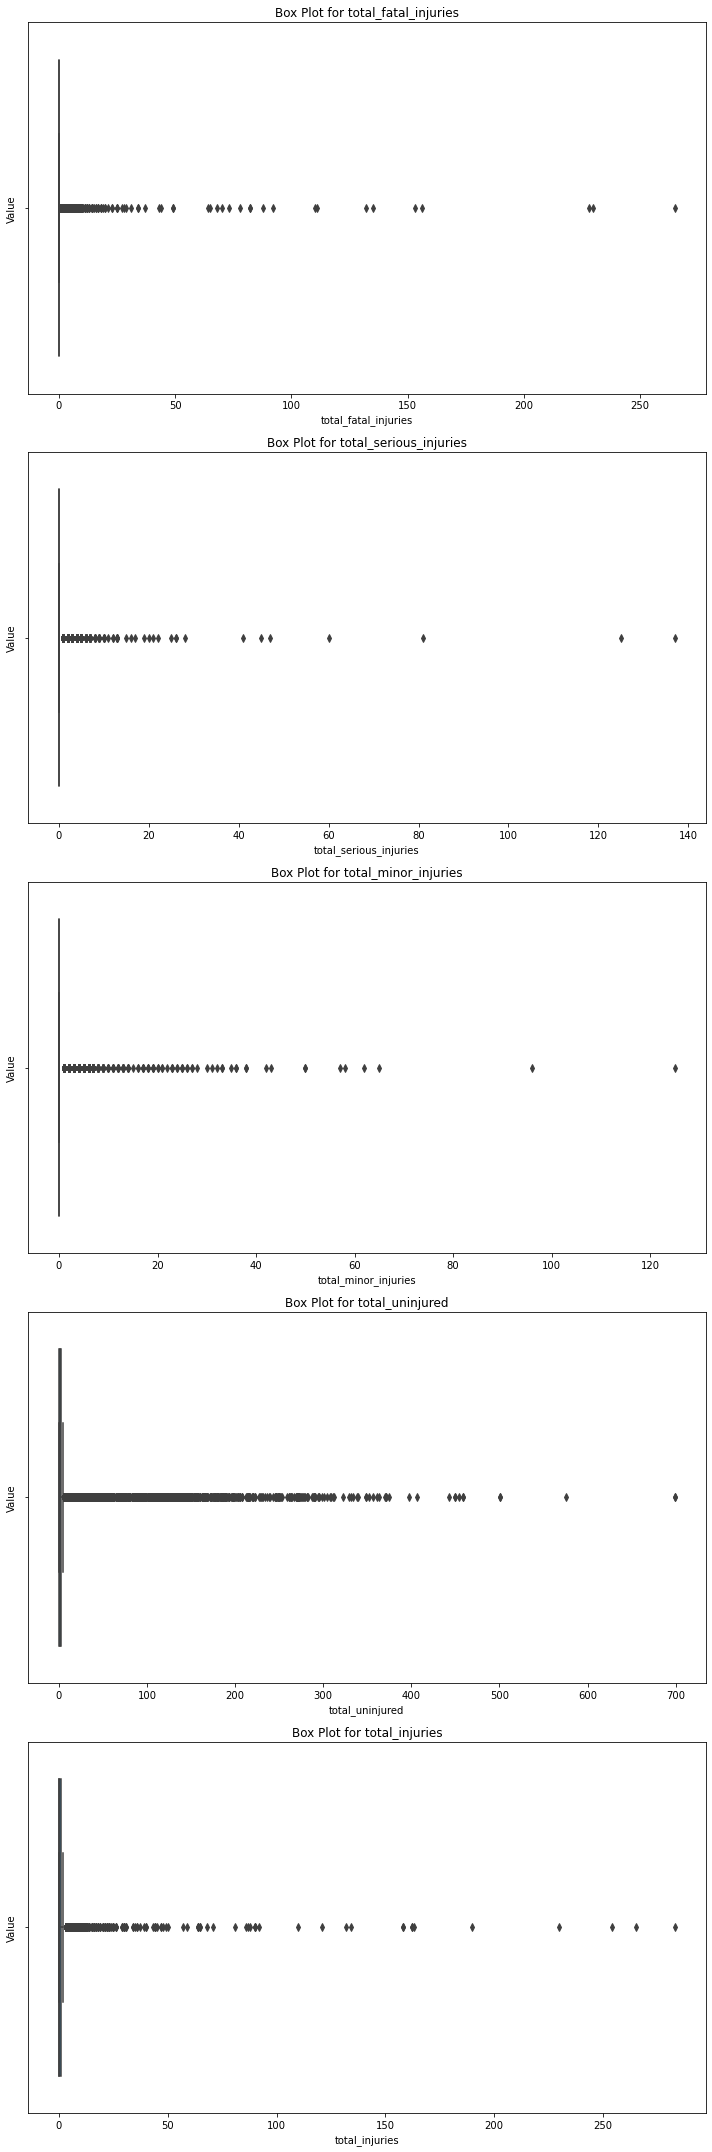

In [44]:
# Create subplots for box plots
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=1, figsize=(10, 6 * len(numerical_columns)))

# Plot each numerical column in a separate subplot
for ax, column in zip(axes, numerical_columns):
    sns.boxplot(data=aviation_df, x=column, ax=ax)
    ax.set_title(f'Box Plot for {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
# Printing out the IQR for each column

for column in numerical_columns:
    Q1 = aviation_df[column].quantile(0.25)
    Q3 = aviation_df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    print(f"{column}")
    print(f"Q1 : {Q1}")
    print(f"Q3 : {Q3}")
    print(f"IQR : {IQR}")

total_fatal_injuries
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
total_serious_injuries
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
total_minor_injuries
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
total_uninjured
Q1 : 0.0
Q3 : 2.0
IQR : 2.0
total_injuries
Q1 : 0.0
Q3 : 1.0
IQR : 1.0


### Explaination of Data

The box and whisker plots above show a line rather than a rectangle for the IQR because the range of the IQR is between 0 and 1. On the graph, when comparing the IQR to the outliers that exist, the range of the outliers far outsizes the range of the IQR.

**Handling Outliers**

Even though the outliers skew the columns, we will keep all of the outliers that are in all of the numerical columns because the outliers are relevant data points that provide useful information for each column. 

# Correlation Analysis

## Numerical Columns Correlation

In [46]:
aviation_df.corr()

,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,total_injuries,year,month,day
total_fatal_injuries,1.000000,0.122479,0.079502,-0.018950,0.814132,-0.020590,0.008230,-0.001619
total_serious_injuries,0.122479,1.000000,0.325473,0.065369,0.548122,0.024718,0.004587,-0.003101
total_minor_injuries,0.079502,0.325473,1.000000,0.167888,0.553061,-0.040301,0.002982,-0.000258
total_uninjured,-0.018950,0.065369,0.167888,1.000000,0.072416,0.032930,-0.001834,-0.001832
total_injuries,0.814132,0.548122,0.553061,0.072416,1.000000,-0.022663,0.008786,-0.002330
year,-0.020590,0.024718,-0.040301,0.032930,-0.022663,1.000000,0.009742,0.002016
month,0.008230,0.004587,0.002982,-0.001834,0.008786,0.009742,1.000000,-0.026778
day,-0.001619,-0.003101,-0.000258,-0.001832,-0.002330,0.002016,-0.026778,1.000000


## Categorical Columns Correlation

# Data Visualization

In [47]:
def create_comparison_bar_chart(dataframe, categorical_col, numerical_col, measure, sort_boolean, num_of_values_shown):
    # Calculate numerical measure for each categorical column
    num_by_cat = dataframe.groupby(categorical_col)[numerical_col].agg(measure)
    
    #Sort the data
    num_by_cat = num_by_cat.sort_values(ascending=sort_boolean).head(num_of_values_shown)
    
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    num_by_cat.plot(kind='bar', color='skyblue')
    plt.title(f'{numerical_col} by {categorical_col}')
    plt.xlabel(f'{categorical_col}')
    plt.ylabel(f'{numerical_col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## What is the most dangerous type of flight?

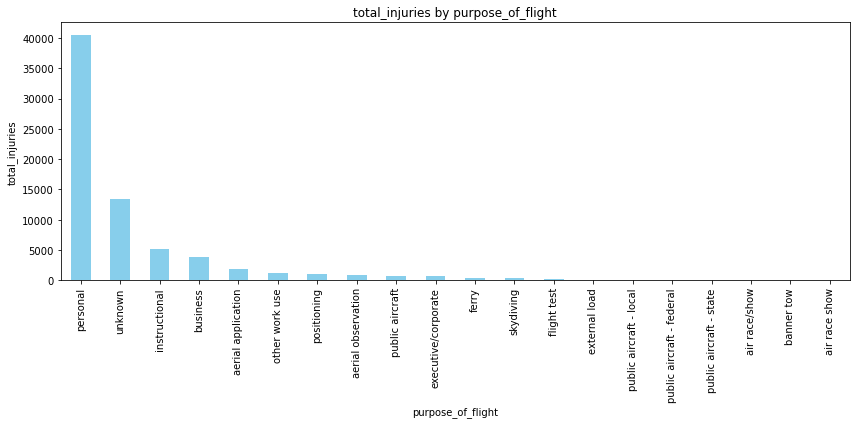

In [48]:
create_comparison_bar_chart(aviation_df, 'purpose_of_flight', 'total_injuries', 'sum', False, 20)

**Review**

Overwhelmingly, the largest cause of injury when onboard an aircraft is while flying for personal reasons. This could be due to a multitude of reasons, cheif among them is flight hours.

Given the data, the hourly requirement should be increased to limit the injuries caused by personal flights. 

"A person applying for a private pilot certificate in airplanes, helicopters, and gyro-planes must log at least 40 hours of flight time, of which at least 20 hours are flight training from an authorized instructor and 10 hours of solo flight training in the appropriate areas of operation; three hours of cross country; three hours at night, three hours of instrument time; and other requirements specific to the category and class rating sought.

Private pilots in gliders and lighter-than-air aircraft must have logged from an authorized instructor a similar number of hours and/ or training flights, which include both cross country and solo according to category and class rating sought. Though the regulations require a minimum of 40 hours flight time, in the U. S. the average number of hours for persons without a hearing impairment completing the private pilot certification requirements is approximately 75 hours."

- https://www.faa.gov/faq/what-are-hourly-requirements-becoming-pilot

In [49]:
categorical_columns = [
    'investigation_type',
    'injury_severity',
    'aircraft_damage',
    'aircraft_category',
    'make',
    'model',
    'amateur_built',
    'number_of_engines',
    'engine_type',
    'purpose_of_flight',
    'weather_condition',
    'broad_phase_of_flight'
]

## Which make and model is most dangerous?

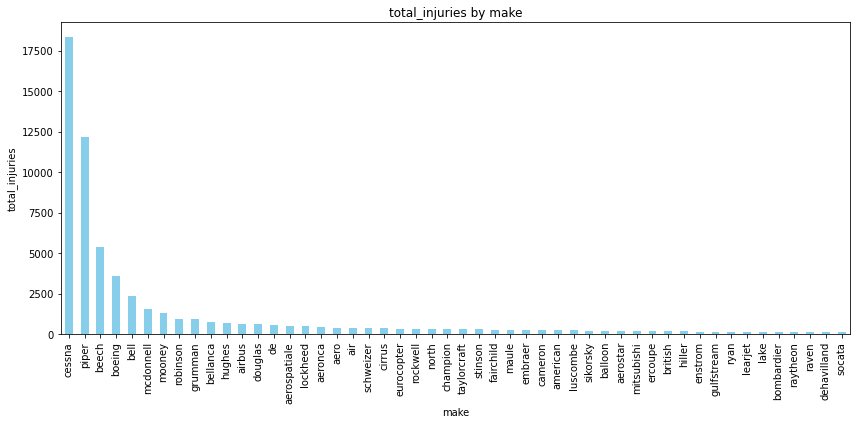

In [50]:
# Filter 'amateur_built' planes so we only see non-amateur or unknown planes
non_amateur_df = aviation_df[(aviation_df['amateur_built'] == 'no') | (aviation_df['amateur_built'] == 'unknown')]

create_comparison_bar_chart(non_amateur_df, 'make', 'total_injuries', 'sum', False, 50)

**Review**



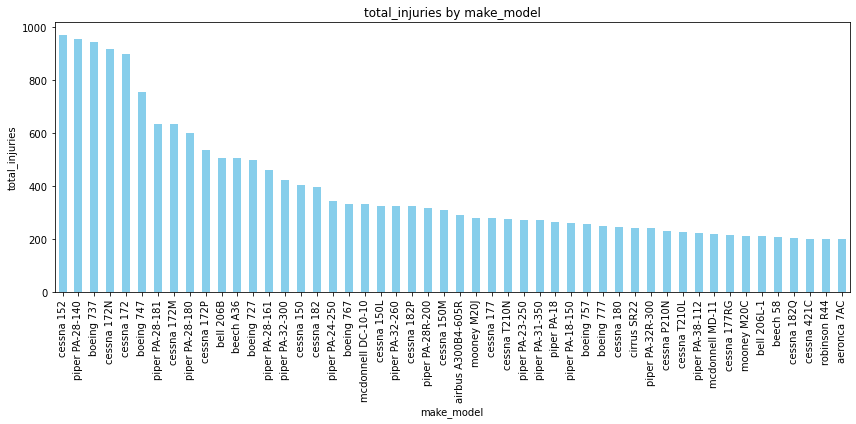

In [51]:
# Create a new column 'make_model' by combining 'make' and 'model' columns
non_amateur_df['make_model'] = non_amateur_df['make'] + ' ' + aviation_df['model']

create_comparison_bar_chart(non_amateur_df, 'make_model', 'total_injuries', 'sum', False, 50)

## Which aircraft is the safest?

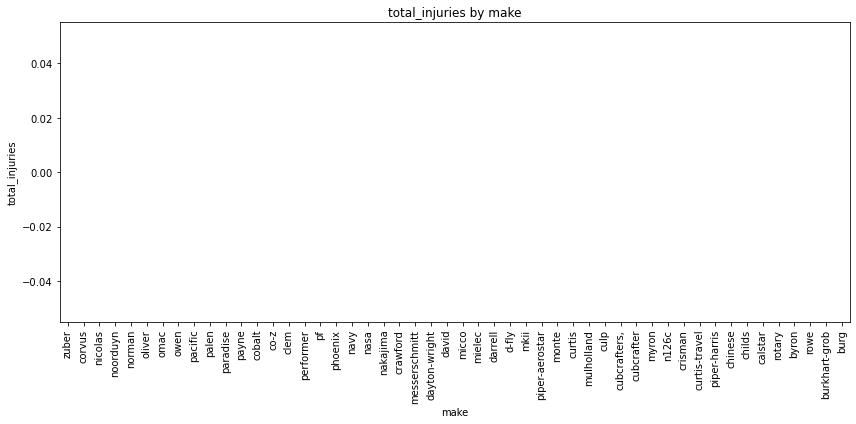

In [52]:
# Filter 'amateur_built' planes so we only see non-amateur or unknown planes
non_amateur_df = aviation_df[(aviation_df['amateur_built'] == 'no') | (aviation_df['amateur_built'] == 'unknown')]

create_comparison_bar_chart(non_amateur_df, 'make', 'total_injuries', 'sum', True, 50)

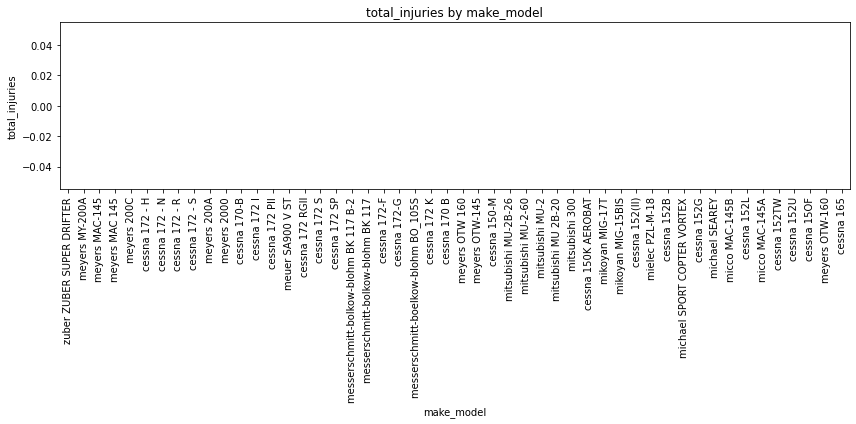

In [53]:
# Create a new column 'make_model' by combining 'make' and 'model' columns
non_amateur_df['make_model'] = non_amateur_df['make'] + ' ' + aviation_df['model']


create_comparison_bar_chart(non_amateur_df, 'make_model', 'total_injuries', 'sum', True, 50)

## Which state has the most accidents?

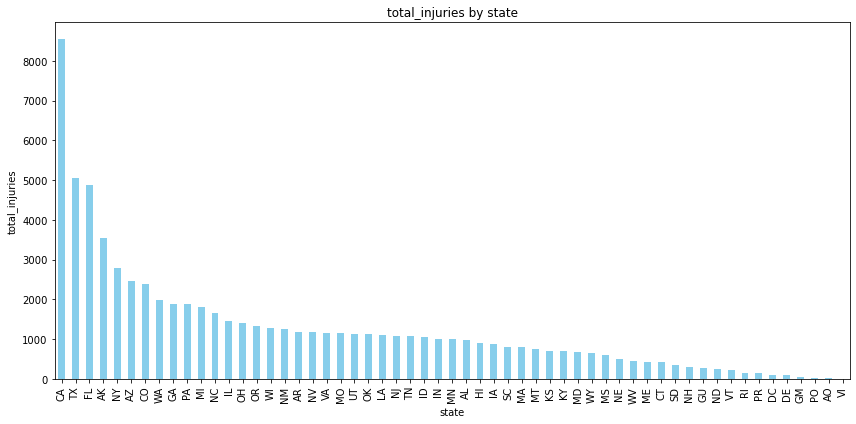

In [54]:
create_comparison_bar_chart(aviation_df, 'state', 'total_injuries', 'sum', False, 100)

## Which weather pattern is most dangerous?

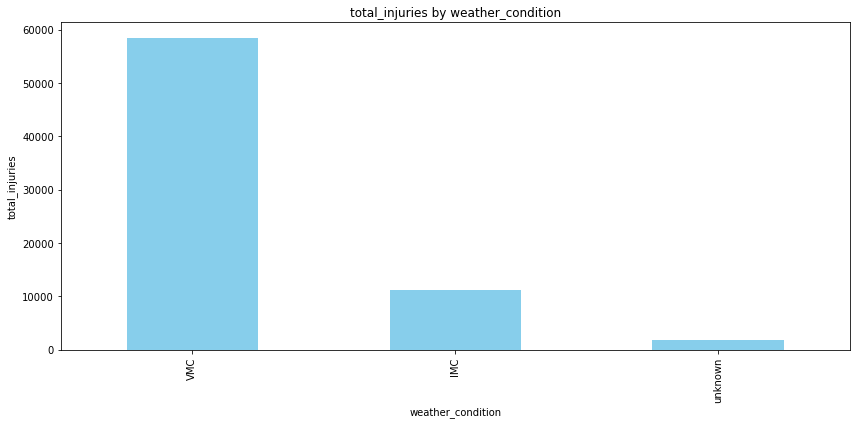

In [55]:
create_comparison_bar_chart(aviation_df, 'weather_condition', 'total_injuries', 'sum', False, 10)

## Which phase of flight of most dangerous?

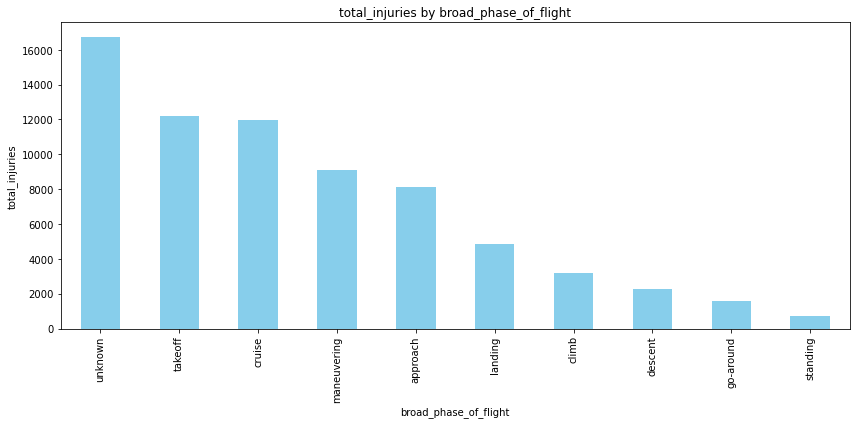

In [56]:
create_comparison_bar_chart(aviation_df, 'broad_phase_of_flight', 'total_injuries', 'sum', False, 10)

## Which engine type is most dangerous?

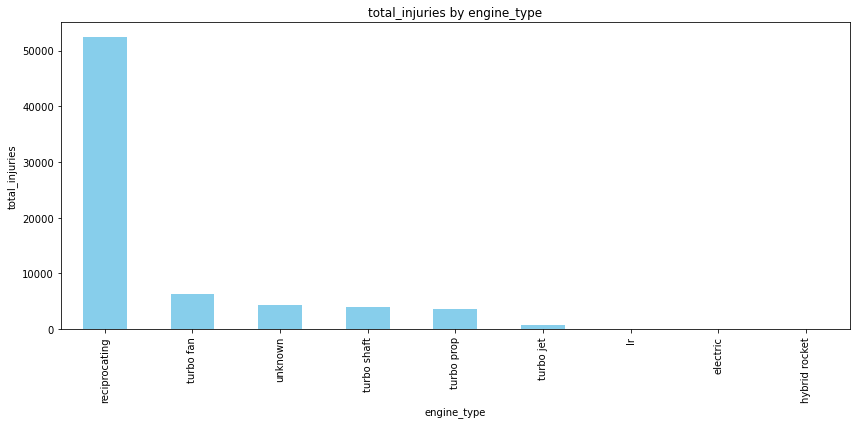

In [57]:
create_comparison_bar_chart(aviation_df, 'engine_type', 'total_injuries', 'sum', False, 10)

## Do the number of engines the aircraft has mitigate the damage done to the aircraft?

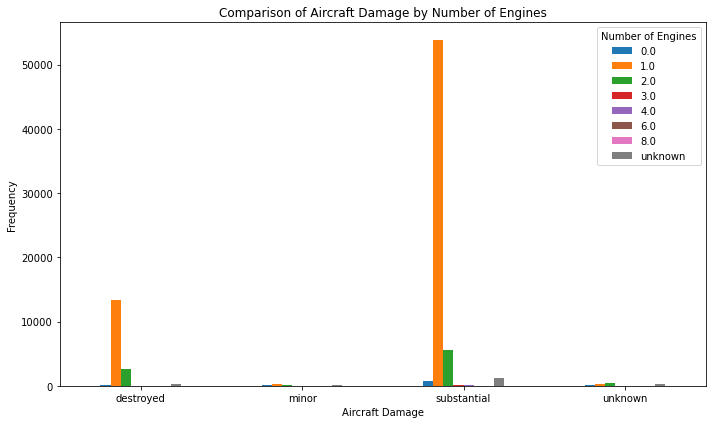

In [58]:
# Group the data by 'aircraft_damage' and 'number_of_engines' and count the frequency of each combination
grouped_data = aviation_df.groupby(['aircraft_damage', 'number_of_engines']).size().unstack(fill_value=0)

# Plot the grouped bar chart
grouped_data.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Aircraft Damage by Number of Engines')
plt.xlabel('Aircraft Damage')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Number of Engines')
plt.tight_layout()
plt.show()

# Trend Analysis

## Number of Avaiation Accidents

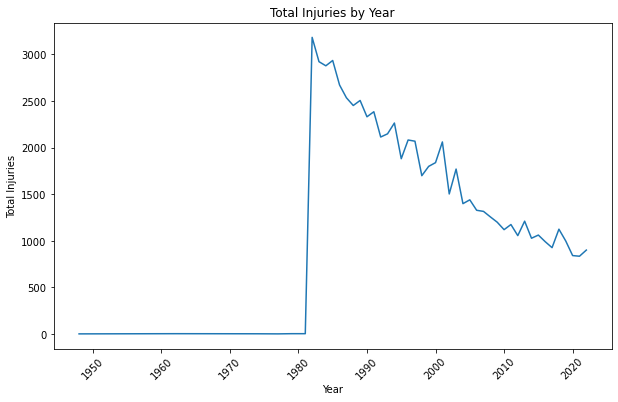

In [59]:
# Group the DataFrame to show pertinent values
yearly_injuries = aviation_df.groupby('year')['total_injuries'].sum()

# Plot the results
yearly_injuries.plot(kind='line', figsize=(10, 6))
plt.title('Total Injuries by Year')
plt.xlabel('Year')
plt.ylabel('Total Injuries')
plt.xticks(rotation=45)
plt.show()

**Review**
There are a few accidents reported prior to 1982. 

**Action**
Filter the DataFrame further to only show accidents from 1982 onward.

### Number of Avaiation Accidents (post 1982)

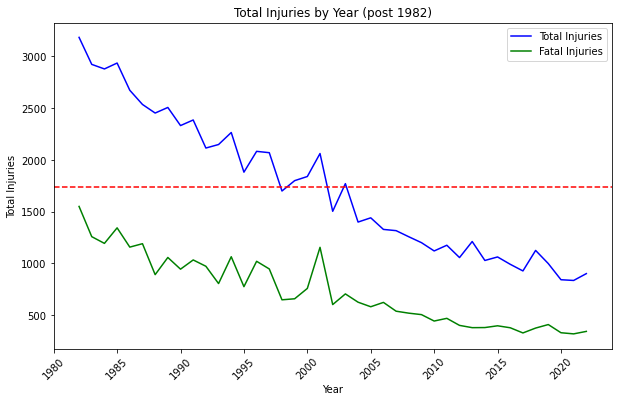

In [60]:
# Filter the DataFrame to show years after 1981
year_1982_plus = aviation_df[(aviation_df['year'] >= 1982)]

# Group the DataFrame to show pertinent values
yearly_injuries = year_1982_plus.groupby('year')['total_injuries'].sum()

yearly_fatal_injuries = year_1982_plus.groupby('year')['total_fatal_injuries'].sum()

# Calculate the mean of total injuries
mean_injuries = yearly_injuries.mean()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(yearly_injuries.index, yearly_injuries.values, linestyle='-', color='b', label='Total Injuries')

# Plot the fatal injuries as a line graph
plt.plot(yearly_fatal_injuries.index, yearly_fatal_injuries.values, linestyle='-', color='g', label='Fatal Injuries')

# Add a horizontal line for the mean
plt.axhline(mean_injuries, color='red', linestyle='--', linewidth=1.5)

# Add titles and labels
plt.title('Total Injuries by Year (post 1982)')
plt.xlabel('Year')
plt.ylabel('Total Injuries')
plt.xticks(rotation=45)
plt.legend()
plt.show()

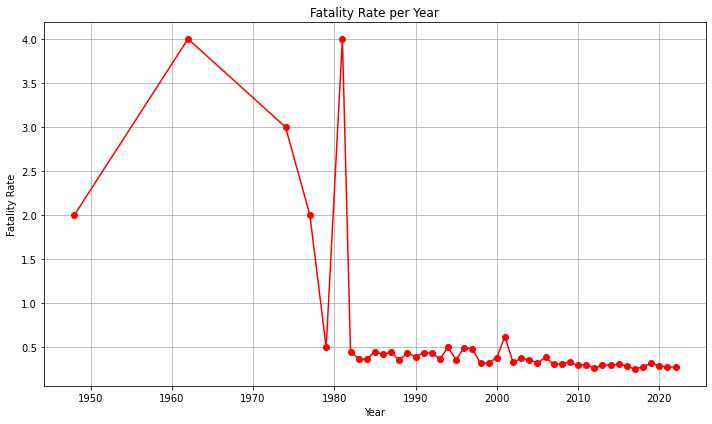

In [61]:
# Calculate the total number of accidents and fatal injuries per year
accidents_per_year = aviation_df.groupby('year').size()
fatal_injuries_per_year = aviation_df.groupby('year')['total_fatal_injuries'].sum()

# Calculate the fatality rate per year
fatality_rate_per_year = fatal_injuries_per_year / accidents_per_year

# Plot the fatality rate over the years
plt.figure(figsize=(10, 6))
fatality_rate_per_year.plot(kind='line', color='red', marker='o')
plt.title('Fatality Rate per Year')
plt.xlabel('Year')
plt.ylabel('Fatality Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

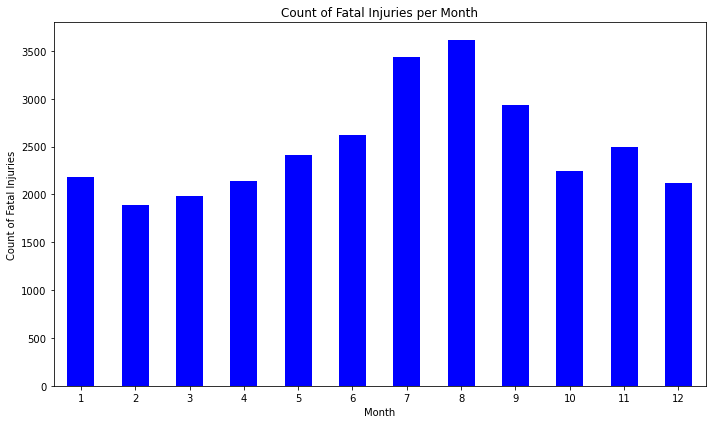

In [62]:
# Calculate the total number of fatal injuries per month
fatal_injuries_per_month = aviation_df.groupby('month')['total_fatal_injuries'].sum()

# Plot the count of fatal injuries for each month
plt.figure(figsize=(10, 6))
fatal_injuries_per_month.plot(kind='bar', color='blue')
plt.title('Count of Fatal Injuries per Month')
plt.xlabel('Month')
plt.ylabel('Count of Fatal Injuries')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Commerical Aircraft

### What is the safest commerical aircraft?

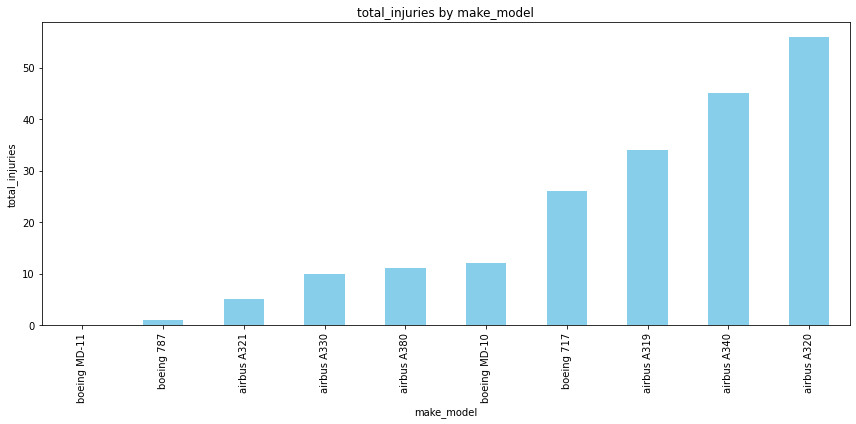

make_model
boeing MD-11      0.0
boeing 787        1.0
airbus A321       5.0
airbus A330      10.0
airbus A380      11.0
boeing MD-10     12.0
boeing 717       26.0
airbus A319      34.0
airbus A340      45.0
airbus A320      56.0
boeing 757      139.0
boeing 707      170.0
boeing 777      241.0
boeing 767      312.0
airbus A300     370.0
boeing 727      452.0
boeing 747      758.0
boeing 737      881.0
Name: total_injuries, dtype: float64


In [100]:
airbus_v_boeing_df = aviation_df[
    (aviation_df['engine_type'] == 'turbo fan') &
    ((aviation_df['make'] == 'airbus') | 
    (aviation_df['make'] == 'boeing'))
]

create_comparison_bar_chart(airbus_v_boeing_df, 'make_model', 'total_injuries', 'sum', True, 10)

# Calculate numerical measure for each categorical column
commercial_aircraft = airbus_v_boeing_df.groupby('make_model')['total_injuries'].sum()

#Sort the data
print(commercial_aircraft.sort_values())

**Analysis**

- Boeing MD-11
    - No longer made. 
        - Only 200 examples built.
        - The last of 200 aircraft was built in October 2000 after Boeing merged with McDonnell Douglas in 1997. 
        - Failed to meet its range and fuel burn targets when it was active. 
    - Many of the MD-11 passenger fleet were converted into freighter specification, many of which are still in service today.
    
- Boeing 787
    - Early 787 operations encountered several problems caused mainly by its lithium-ion batteries, including fires onboard some aircraft. 
        - In January 2013, the U.S. FAA grounded all 787s until it approved the revised battery design in April 2013. 
        - Significant quality control issues from 2019 onwards caused a production slowdown and, from January 2021 until August 2022, an almost total cessation of deliveries. 
        - Boeing has spent 32 billion on the program; estimates for the number of aircraft sales needed to break even vary between 1,300 and 2,000. 
        - **As of April 2024, the 787 program has received 1,915 orders and made 1,127 deliveries with no fatalities and no hull losses.**
        
- Airbus A321
    - First flight on 11 March 1993 
    - Still in production.
    - Safety:
        - The aircraft shares a common type rating with all other Airbus A320-family variants, allowing A320-family pilots to fly the aircraft without the need for further training. 
        
- Airbus A330
    - First flight on 2 November 1992. 
    - Still in production.
    - The global A330 fleet had accumulated more than 65 million flight hours since its entry into service.
    
        
- Airbus A380
    - Airbus ended production of the A380 in 2021.
    - As of December 2021, the global A380 fleet had completed more than 800,000 flights over 7.3 million block hours with no fatalities and no hull losses. As of December 2022, there were 237 aircraft in service with 16 operators worldwide. 

- Boeing MD-10
    - Data is missing.
        - Original cargo doors that caused multiple incidents, including fatalities. Most notably the crash of Turkish Airlines Flight 981 in Paris in 1974, the deadliest crash in aviation history up to that time. 
    - Production ended in 1989
    - In February 2014, the DC-10 made its last commercial passenger flight.

# Document Your Finding